Results from Level IW algorithm (for boxplot and accuracy timelime).
Keyboard patterns database. 10 features. 4 classes.
8 batches of 190 instances



METHOD: Static nb as classifier
Execution time:  0.006094624507209293
Average micro-F1: 0.53125
Average Accuracy:  51.1175
Standard Deviation:  9.9026786149
Variance:  98.06304375


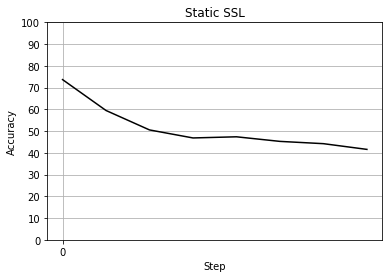

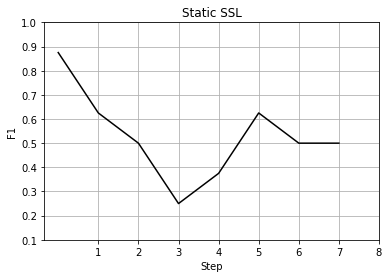




METHOD: Sliding nb as classifier
Execution time:  0.009814925212750902
Average micro-F1: 0.6875
Average Accuracy:  67.36875
Standard Deviation:  4.94350441868
Variance:  24.4382359375


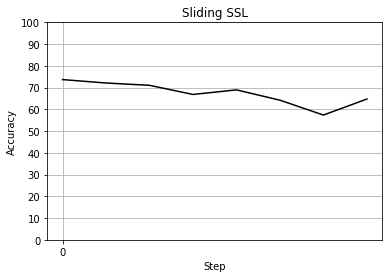

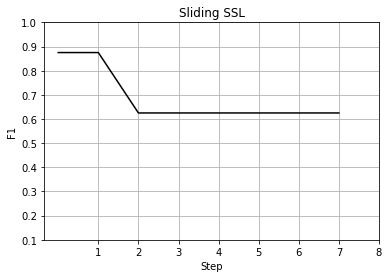




METHOD: Incremental nb as classifier
Execution time:  0.013341645441950156
Average micro-F1: 0.640625
Average Accuracy:  65.0
Standard Deviation:  4.56486856328
Variance:  20.838025


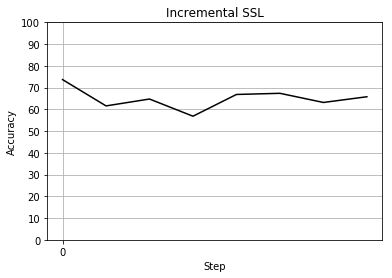

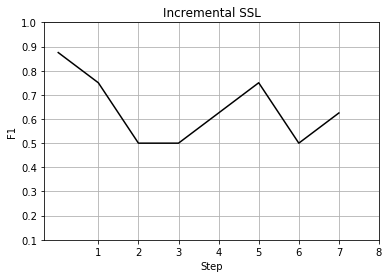




METHOD: nb as classifier and kde as core support extraction with cutting data method
Execution time:  0.051365986804132624
Average micro-F1: 0.65625
Average Accuracy:  62.2375
Standard Deviation:  12.3328339707
Variance:  152.09879375


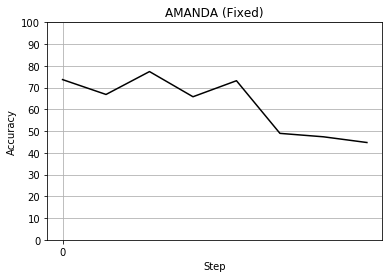

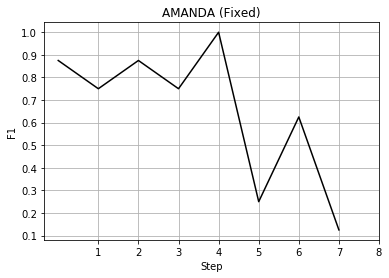




METHOD: nb as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  1.3840194180970882
Average micro-F1: 0.703125
Average Accuracy:  66.9725
Standard Deviation:  3.58490847163
Variance:  12.85156875


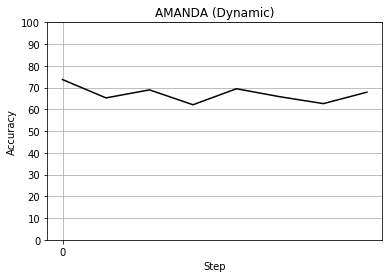

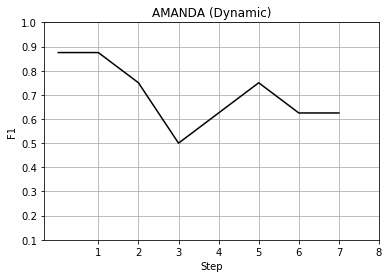




METHOD: None as classifier and GMM with BIC and Mahalanobis as core support extraction
Execution time:  1.8880172499957526
Average micro-F1: 0.953125
Average Accuracy:  87.37
Standard Deviation:  3.55114066182
Variance:  12.6106


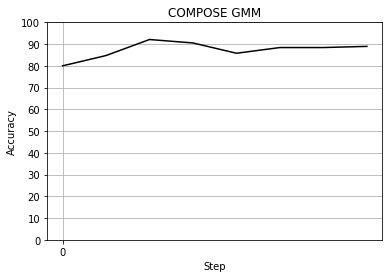

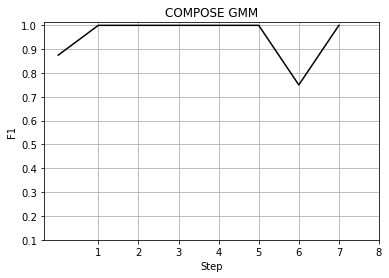




Method: Level IW
Execution time:  1.8880172499957526
Average F1:  0.21875
Average Accuracy:  87.0394875
Standard Deviation:  1.57756740699
Variance:  2.48871892359


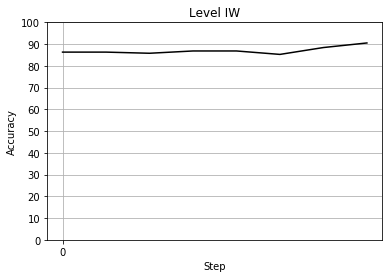

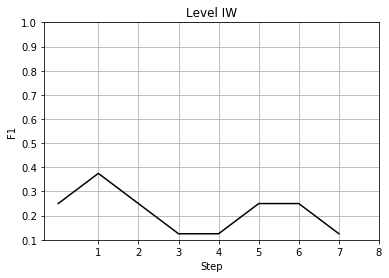

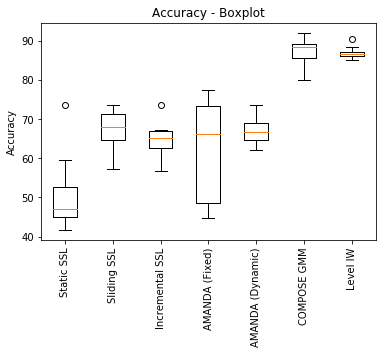

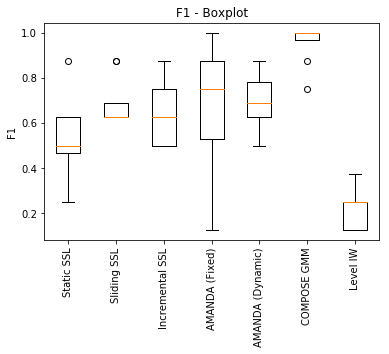

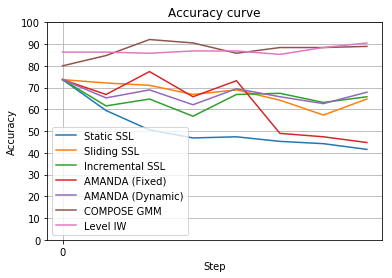

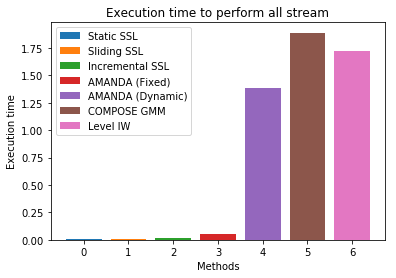

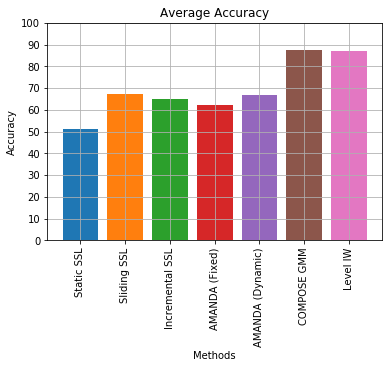

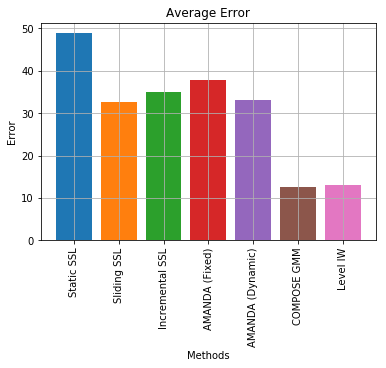

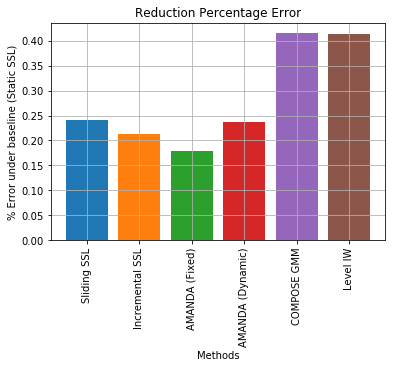

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, nb = naive bayes, knn = k-nn, sgd = stochastic gradient descent
    steps = 8
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadKeystroke(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 2, 0.9, "kde", clfName=sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 2, None, "kde", clfName=sslClassifier)

    # COMPOSE GMM (Python version)
    experiments[5] = Experiment(compose_gmm_version, 2)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'keystroke', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()